In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', 200)
#pd.set_option("display.max_columns", 999)

import os
from multiprocessing import Pool
import psutil

import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())

2023-07-10 15:39:02.126385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 15:39:02.455541: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.10.0
True


In [2]:
def read_training_files(FileName):
    print("Training file: " + FileName + "\n")
    return pd.read_csv(FileName, header=0, skipinitialspace=True, nrows=100000) #training 0-100k events

In [3]:
def read_testing_files(FileName):
    print("Testing file: " + FileName + "\n")
    return pd.read_csv(FileName, header=0, skipinitialspace=True, skiprows=range(1,100000), nrows=50000) #testing 100-150k events

In [4]:
Masses = [500, 600, 700, 800, 900, 1000]
Files = ["tree_ML_MCRun2_" + str(Mass) + "GeV.csv" for Mass in Masses]

In [5]:
#multithreading and memory monitoring in case large input files in the future
FileSize = 0
for File in Files:
    FileSize += os.path.getsize(File)
    
Mem0 = psutil.virtual_memory().available

TrainingDF = None
TestingDF = None
with Pool(processes=6) as pool:
    TrainingDF = pd.concat(pool.map(read_training_files, Files))
    TestingDF = pd.concat(pool.map(read_testing_files, Files))

Mem1 = psutil.virtual_memory().available
print("Total file size: " + str(FileSize/(1024**3)) + "GB")
print("Memory used: " + str((Mem0 - Mem1)/(1024**3)) + "GB")

Training file: tree_ML_MCRun2_600GeV.csv
Training file: tree_ML_MCRun2_700GeV.csv
Training file: tree_ML_MCRun2_1000GeV.csv


Training file: tree_ML_MCRun2_500GeV.csv
Training file: tree_ML_MCRun2_900GeV.csv


Training file: tree_ML_MCRun2_800GeV.csv


Testing file: tree_ML_MCRun2_600GeV.csv
Testing file: tree_ML_MCRun2_900GeV.csv
Testing file: tree_ML_MCRun2_1000GeV.csv
Testing file: tree_ML_MCRun2_800GeV.csv
Testing file: tree_ML_MCRun2_500GeV.csv
Testing file: tree_ML_MCRun2_700GeV.csv






Total file size: 0.24597379937767982GB
Memory used: 0.15357589721679688GB


In [6]:
TrainingDF

,M4,R1,R2,R3,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,Mass
0,1.615654,0.596896,0.527062,0.299362,673.560446,735.403596,467.350343,2,2,2,500
1,2.238177,0.702622,0.460715,0.456434,843.196643,751.618344,734.565978,0,2,2,500
2,1.484222,0.685523,0.526373,0.391565,667.119136,490.161812,442.064040,1,2,1,500
3,2.021423,0.657197,0.486695,0.410394,905.289977,692.212922,689.326225,1,2,2,500
4,1.884465,0.650958,0.516887,0.294112,833.344354,760.449872,553.798213,2,2,2,500
...,...,...,...,...,...,...,...,...,...,...,...
99995,1.883865,0.534234,0.460678,0.422482,701.852326,792.379708,747.236665,2,0,1,1000
99996,3.038430,0.600369,0.408263,0.343466,1364.490847,1222.766722,1028.080867,2,2,2,1000
99997,2.490334,0.684008,0.436359,0.414619,947.242015,867.391259,914.904419,0,2,0,1000
99998,2.262540,0.516382,0.450869,0.436098,672.436144,955.081704,976.120934,0,2,2,1000


In [7]:
#reset indext from 0-100k x 6 to 0-600k
TrainingDF = TrainingDF.reset_index(drop=True)
TestingDF = TestingDF.reset_index(drop=True)

In [8]:
TrainingDF.dtypes

M4            float64
R1            float64
R2            float64
R3            float64
P1M           float64
P2M           float64
P3M           float64
dRi             int64
Truth_high      int64
Truth_avg       int64
Mass            int64
dtype: object

(array([100000., 100000., 100000., 100000., 100000., 100000.]),
 array([ 450.,  550.,  650.,  750.,  850.,  950., 1050.]),
 <BarContainer object of 6 artists>)

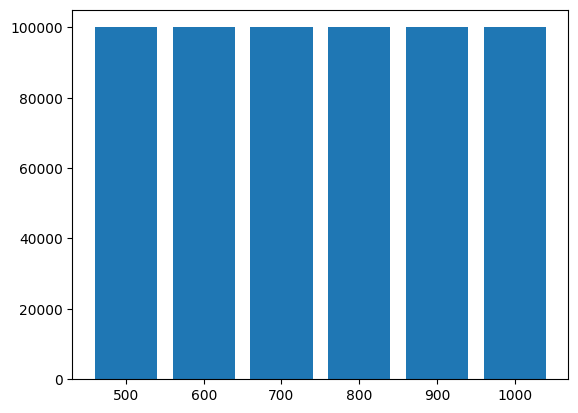

In [9]:
plt.hist(TrainingDF["Mass"], bins = len(Masses), range = [450, 1050], rwidth = 0.8)

(array([50000., 50000., 50000., 50000., 50000., 50000.]),
 array([ 450.,  550.,  650.,  750.,  850.,  950., 1050.]),
 <BarContainer object of 6 artists>)

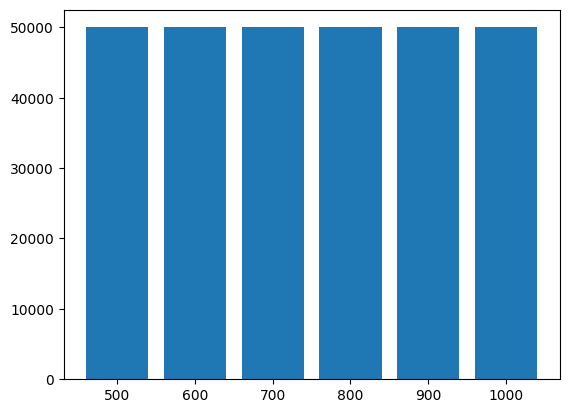

In [10]:
plt.hist(TestingDF["Mass"], bins = len(Masses), range = [450, 1050], rwidth = 0.8)

In [11]:
TrainingInputs = TrainingDF[['M4', 'R1', 'R2', 'R3']].to_numpy()
TrainingTruth = TrainingDF["Truth_high"].to_numpy()

TestingInputs = TestingDF[['M4', 'R1', 'R2', 'R3']].to_numpy()

In [12]:
print(TrainingInputs.shape)
print(TrainingTruth.shape)
print(TestingInputs.shape)

(600000, 4)
(600000,)
(300000, 4)


In [13]:
def model_DNN_lite():
    Model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')],
        name = "ModelDNNLite"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [14]:
def model_DNN():
    Model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')],
        name = "ModelDNN"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [15]:
Model = model_DNN_lite()
#Model = model_DNN()

2023-07-10 15:39:07.137847: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 15:39:08.002842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10845 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:65:00.0, compute capability: 6.0


In [16]:
Model.fit(TrainingInputs, TrainingTruth, batch_size = 1024,
          epochs = 20, validation_split = 0.2)

Epoch 1/20
469/469 [==============================] - 2s 3ms/step - loss: 0.8393 - accuracy: 0.5600 - val_loss: 1.2903 - val_accuracy: 0.3764
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 0.7476 - accuracy: 0.6273 - val_loss: 1.2985 - val_accuracy: 0.4057
Epoch 3/20
469/469 [==============================] - 1s 2ms/step - loss: 0.6947 - accuracy: 0.6502 - val_loss: 1.3618 - val_accuracy: 0.4133
Epoch 4/20
469/469 [==============================] - 1s 2ms/step - loss: 0.6841 - accuracy: 0.6543 - val_loss: 1.2604 - val_accuracy: 0.4372
Epoch 5/20
469/469 [==============================] - 1s 2ms/step - loss: 0.6774 - accuracy: 0.6558 - val_loss: 1.3522 - val_accuracy: 0.4268
Epoch 6/20
469/469 [==============================] - 1s 2ms/step - loss: 0.6716 - accuracy: 0.6578 - val_loss: 1.3485 - val_accuracy: 0.4340
Epoch 7/20
469/469 [==============================] - 1s 2ms/step - loss: 0.6678 - accuracy: 0.6589 - val_loss: 1.4169 - val_accuracy: 0.4292
Epoch 

In [17]:
Model.summary()

Model: "ModelDNNLite"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 3)                 27        
                                                                 
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________


In [18]:
TestingOutputs = Model.predict(TestingInputs, batch_size = 1024)

293/293 [==============================] - 0s 1ms/step


In [19]:
TestingOutputs[0] #ML raw output is the probability of 3 sparse categories

array([0.08140423, 0.8889249 , 0.02967088], dtype=float32)

In [20]:
TestingPredictions = np.argmax(TestingOutputs, axis = 1) #pick the highest probability as ML output

In [21]:
print(TestingPredictions.shape)
print(TestingPredictions[0])

(300000,)
1


In [22]:
TestingDF = TestingDF.drop(columns=["M4", "R1", "R2", "R3"])
TestingDF["Pred"] = TestingPredictions.tolist()

In [23]:
TestingDF

,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,Mass,Pred
0,535.681346,435.772373,285.874005,2,1,0,500,1
1,450.785098,534.585277,472.124324,0,2,2,500,2
2,532.628989,629.852393,569.474171,0,2,0,500,2
3,570.249968,463.143578,330.376313,2,1,1,500,1
4,640.617487,615.598976,333.228788,2,2,1,500,2
...,...,...,...,...,...,...,...,...
299995,811.985728,729.131024,783.180025,1,2,0,1000,2
299996,433.114600,400.973399,418.424179,1,0,0,1000,2
299997,1034.103896,960.191267,676.695534,2,1,0,1000,2
299998,1206.141640,977.816285,835.481783,2,2,1,1000,2


In [24]:
AccPred = []
AccdR = []
Acc0 = []
Acc1 = []
Acc2 = []
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    TestingDF_pred = TestingDF_temp.loc[TestingDF_temp["Pred"]==TestingDF_temp["Truth_high"]]
    TestingDF_dR = TestingDF_temp.loc[TestingDF_temp["dRi"]==TestingDF_temp["Truth_high"]]
    TestingDF_0 = TestingDF_temp.loc[0==TestingDF_temp["Truth_high"]]
    TestingDF_1 = TestingDF_temp.loc[1==TestingDF_temp["Truth_high"]]
    TestingDF_2 = TestingDF_temp.loc[2==TestingDF_temp["Truth_high"]]

    AccPred.append(float(len(TestingDF_pred.index))/len(TestingDF_temp.index))
    AccdR.append(float(len(TestingDF_dR.index))/len(TestingDF_temp.index))
    Acc0.append(float(len(TestingDF_0.index))/len(TestingDF_temp.index))
    Acc1.append(float(len(TestingDF_1.index))/len(TestingDF_temp.index))
    Acc2.append(float(len(TestingDF_2.index))/len(TestingDF_temp.index))

In [25]:
print(AccPred, "Average %.2f" % float(sum(AccPred)/len(AccPred)))
print(AccdR, "Average %.2f" % float(sum(AccdR)/len(AccdR)))
print(Acc0, "Average %.2f" % float(sum(Acc0)/len(Acc0)))
print(Acc1, "Average %.2f" % float(sum(Acc1)/len(Acc1)))
print(Acc2, "Average %.2f" % float(sum(Acc2)/len(Acc2)))

[0.63656, 0.7233, 0.70464, 0.6649, 0.55592, 0.43486] Average 0.62
[0.544, 0.39856, 0.33912, 0.30848, 0.2907, 0.2741] Average 0.36
[0.02722, 0.10198, 0.1671, 0.19664, 0.21688, 0.22934] Average 0.16
[0.1966, 0.32604, 0.35396, 0.37766, 0.38838, 0.39698] Average 0.34
[0.77618, 0.57198, 0.47894, 0.4257, 0.39474, 0.37368] Average 0.50


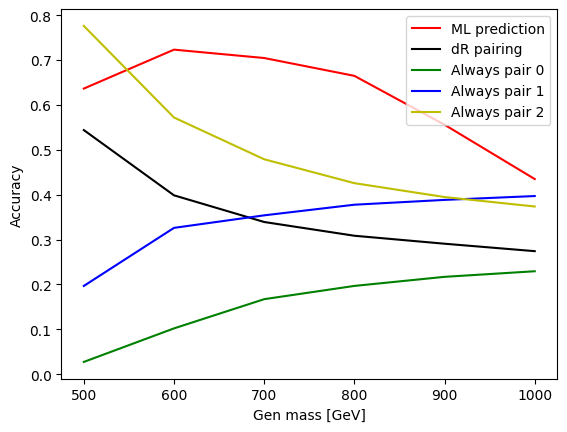

In [26]:
plt.plot(Masses, AccPred, "r", label = "ML prediction")
plt.plot(Masses, AccdR, "k", label = "dR pairing")
plt.plot(Masses, Acc0, "g", label = "Always pair 0")
plt.plot(Masses, Acc1, "b", label = "Always pair 1")
plt.plot(Masses, Acc2, "y", label = "Always pair 2")
plt.legend(loc="upper right")
plt.xlabel("Gen mass [GeV]")
plt.ylabel("Accuracy")
plt.savefig("plots/" + Model.name + "_Acc_vs_mass.png")

In [27]:
#TestingDF["dR_M"] = TestingDF.apply(lambda row: row.iloc[row["dRi"]], axis=1)
TestingDF["dR_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), TestingDF["dRi"]]
TestingDF["Truth_high_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), TestingDF["Truth_high"]]
TestingDF["Truth_avg_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), TestingDF["Truth_avg"]]
TestingDF["Pred_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), TestingDF["Pred"]]
TestingDF

,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,Mass,Pred,dR_M,Truth_high_M,Truth_avg_M,Pred_M
0,535.681346,435.772373,285.874005,2,1,0,500,1,285.874005,435.772373,535.681346,435.772373
1,450.785098,534.585277,472.124324,0,2,2,500,2,450.785098,472.124324,472.124324,472.124324
2,532.628989,629.852393,569.474171,0,2,0,500,2,532.628989,569.474171,532.628989,569.474171
3,570.249968,463.143578,330.376313,2,1,1,500,1,330.376313,463.143578,463.143578,463.143578
4,640.617487,615.598976,333.228788,2,2,1,500,2,333.228788,333.228788,615.598976,333.228788
...,...,...,...,...,...,...,...,...,...,...,...,...
299995,811.985728,729.131024,783.180025,1,2,0,1000,2,729.131024,783.180025,811.985728,783.180025
299996,433.114600,400.973399,418.424179,1,0,0,1000,2,400.973399,433.114600,433.114600,418.424179
299997,1034.103896,960.191267,676.695534,2,1,0,1000,2,676.695534,960.191267,1034.103896,676.695534
299998,1206.141640,977.816285,835.481783,2,2,1,1000,2,835.481783,835.481783,977.816285,835.481783


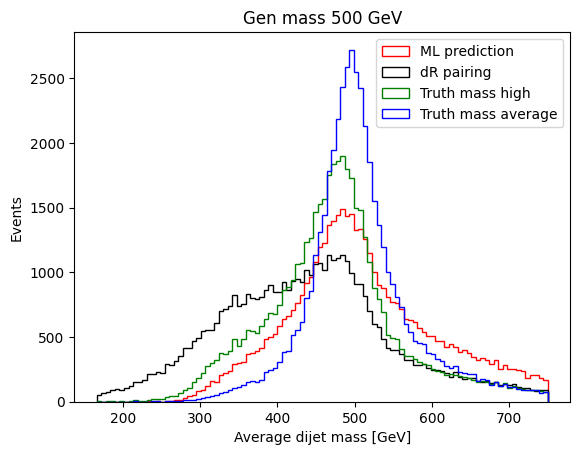

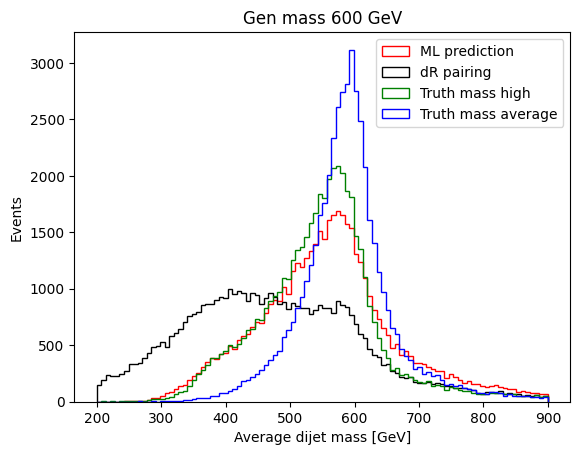

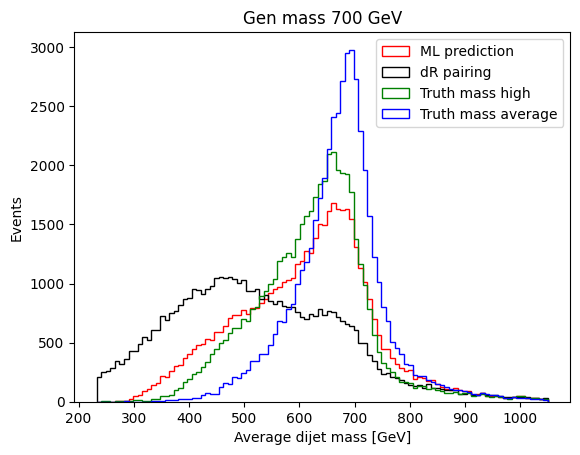

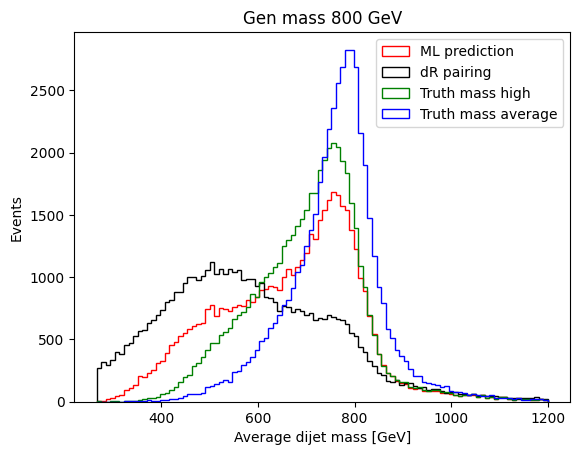

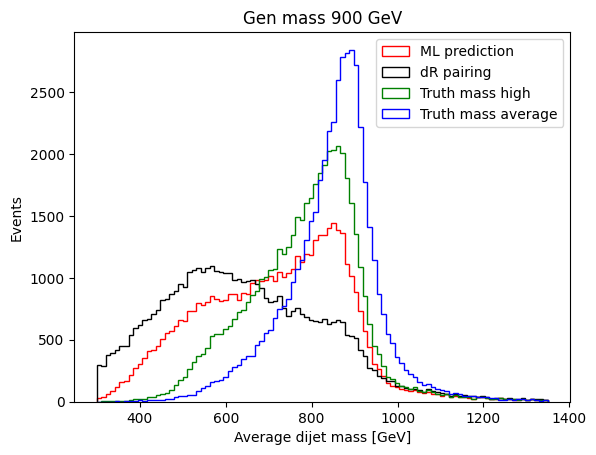

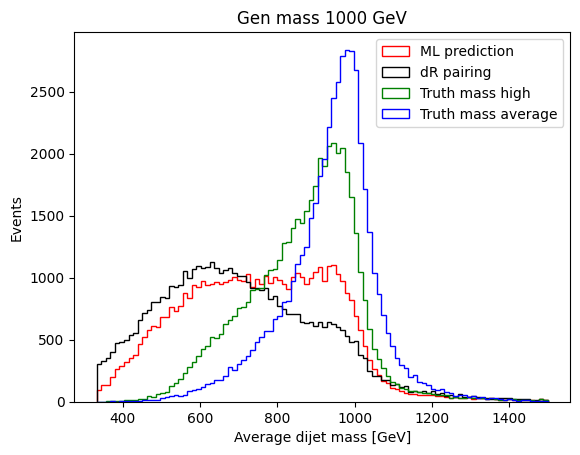

In [28]:
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    plt.figure()
    plt.hist(TestingDF_temp["Pred_M"], bins = 100, range = [Mass/3, Mass*1.5], histtype = "step", color = "r", label = "ML prediction")
    plt.hist(TestingDF_temp["dR_M"], bins = 100, range = [Mass/3, Mass*1.5], histtype = "step", color = "k", label = "dR pairing")
    plt.hist(TestingDF_temp["Truth_high_M"], bins = 100, range = [Mass/3, Mass*1.5], histtype = "step", color = "g", label = "Truth mass high")
    plt.hist(TestingDF_temp["Truth_avg_M"], bins = 100, range = [Mass/3, Mass*1.5], histtype = "step", color = "b", label = "Truth mass average")
    plt.legend(loc="upper right")
    plt.title("Gen mass " + str(Mass) + " GeV")
    plt.xlabel("Average dijet mass [GeV]")
    plt.ylabel("Events")
    plt.show()